In [1]:
import numpy as np
from itertools import cycle
import os
import dask.array as da
import dask.bag as db
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
import datetime as dt
import subprocess
from scipy.ndimage import binary_fill_holes
from importlib import reload
os.chdir("/home/149/ab8992/cosima_regional/development/regional-mom6")
import regional_mom6 as rm
# import boundary_tides as bt
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35021/status,
Dashboard: /proxy/35021/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45995,Workers: 7
Dashboard: /proxy/35021/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:42315,Total threads: 4
Dashboard: /proxy/40561/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:45669,


# TTide domain

In [2]:

## Choose your coordinates and the name of your experiment


yextent = [-56,-26]
xextent = [142,180]
expt_name = "blank-80"


daterange = ["2015-01-01 00:00:00", "2015-12-31 00:00:00"]

## Place where all your input files go
inputdir = f"/scratch/v45/ab8992/mom6_regional_configs/ttide-runs/{expt_name}/"

## Directory where you'll run the experiment from
rundir = f"/home/149/ab8992/mom6_rundirs/ttide/{expt_name}/"

## Directory where raw downloads go before processing
tmpdir = f"/scratch/v45/ab8992/regional_tmp/ttide-20"

## Directory where fre tools are stored
toolpath = "/home/157/ahg157/repos/mom5/src/tools/" ## Compiled tools needed for construction of mask tables
for i in [rundir,tmpdir,inputdir]:
    if not os.path.exists(i):
        subprocess.run(f"mkdir {i} -p",shell=True)

## I'm going to generate the ocean forcing again!

There's a bug in the code I found while making blank tides. There are NaNs down at the seafloor in the tracers (in non blank case) but NOT in the vels for some reason. Try and remove these and then carry on as before

### Actually, troubleshoot the interpolation. It's getting stuck with tracers that have an offset value

In [3]:
expt = rm.experiment(
    xextent,
    yextent,
    daterange,
    0.0125,  ## Resolution
    100,      ## #zlayers
    20,       ## dz ratio
    5500,    ## Max depth of ocean
    rundir,
    inputdir,
    toolpath
)

# expt.processor_mask((25,20))


KeyboardInterrupt: 

In [48]:
a = expt.ocean_forcing(
    tmpdir,  ## Path to ocean foring files
    {"time":"time","y":"latitude","x":"longitude",
     "zl":"depth","eta":"zos","u":"uo","v":"vo",
     "tracers":{"salt":"so","temp":"thetao"}},
    boundaries = ["south","north","west","east"]
    )

INITIAL CONDITIONS
Regridding Velocities...Done.
Regridding Tracers...
Done.
Regridding Free surface...
Saving outputs... done.
BRUSHCUT BOUNDARIES
[########################################] | 100% Completed | 209.51 ms
Done.
[########################################] | 100% Completed | 207.35 ms
Done.
[########################################] | 100% Completed | 206.43 ms
Done.
[########################################] | 100% Completed | 207.19 ms
Done.


## Read in ocean boundary files, modify, resave

| variable | method | 
|---|---|
|salt | Average horizontally |
|velocity | zero everywhere |
|eta | average horizontally|
|temperature | average horizontally | 
| era5 inputs | average horizontally, first timestep only |

In [2]:
## OCEAN INITIAL CONDITIONS

inputdir = "/g/data/nm03/ab8992/ttide-inputs/blank-80/"


file = xr.open_dataset(inputdir + "forcing/init_vel.nc",chunks = "auto")
file["u"][:,:] = 0
file["v"][:,:] = 0
file.to_netcdf(inputdir + "forcing/newinit_vel.nc")
file.close()

file = xr.open_dataset(inputdir + "forcing/init_eta.nc",chunks = "auto")
print(file)
file["eta_t"][:,:] = 0
file.to_netcdf(inputdir + "forcing/newinit_eta.nc")
file.close()


file = xr.open_dataset(inputdir + "forcing/init_tracers.nc",chunks = {"xh":100,"yh":100})
tempmean = file.temp.mean(dim = ["xh", "yh"])
saltmean = file.salt.mean(dim = ["xh", "yh"])

file["salt"][:,:,:] = (file.salt.transpose("xh","yh","zl") * 0 + saltmean ).transpose("zl","yh","xh") 
file["temp"][:,:,:] = (file.temp.transpose("xh","yh","zl") * 0 + tempmean ).transpose("zl","yh","xh") 

file.to_netcdf(inputdir + "forcing/newinit_tracers.nc",mode = "w")
file.close()

0.3.0
<xarray.Dataset>
Dimensions:  (xh: 3040, yh: 3180)
Coordinates:
    time     datetime64[ns] ...
  * xh       (xh) float64 142.0 142.0 142.0 142.0 ... 180.0 180.0 180.0 180.0
  * yh       (yh) float64 -56.0 -55.99 -55.98 -55.97 ... -26.02 -26.01 -26.0
Data variables:
    eta_t    (yh, xh) float32 dask.array<chunksize=(3180, 3040), meta=np.ndarray>


In [4]:
## Cheat by getting saltmean, tempmean from smaller run 
inputdir = "/g/data/nm03/ab8992/ttide-inputs/blank-20/"

file = xr.open_dataset(inputdir + "forcing/init_tracers.nc",chunks = {"xh":100,"yh":100})
tempmean = file.temp.mean(dim = ["xh", "yh"])
saltmean = file.salt.mean(dim = ["xh", "yh"])

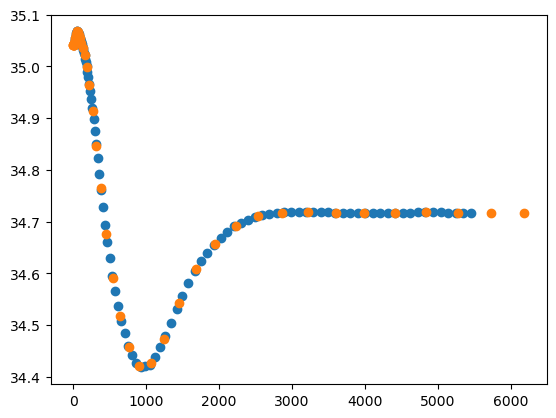

In [38]:
plt.scatter(saltmean.zl.values,saltmean.values)
plt.scatter(zl_seg,out_seg_salt)


## Interpolate mean interior values onto boundary

First, get segment zl profile by taking the cumsum of segment's dz field. Then use this as xax on which to interpolate the *initial condition's* mean value 


I've confirmed that zl levels are the same for each boundary. Therefore we generate the profile once, and reuse for every boundary so they're identical

`out_seg_salt` and `out_seg_temp` will be used as boundary values for every segment after exectuting below cell

** Potential problem **

The initial condition contains two NaN values at the bottom which might not necessarily be present at the bottom of each OBC? I might be imposing this. Should let each OBC prescribe where the NaNs are

In [5]:
inputdir = "/g/data/nm03/ab8992/ttide-inputs/blank-80/"

i = "001"
file = xr.open_dataset(f"{inputdir}/forcing/forcing_obc_segment_{i}.nc",chunks={f"ny_segment_{i}":50,f"nx_segment_{i}":50},decode_times=False)
tempmean_seg = file[f"temp_segment_{i}"].isel(time = 0).mean(dim = [f"ny_segment_{i}", f"nx_segment_{i}"]) * 0

zl_seg = file.dz_temp_segment_001.isel(time = 0,ny_segment_001 = 0,nx_segment_001 = 0).cumsum()
zl_ic = tempmean.zl.values
file.close()
## Now we interpolate tempmean from zl_ic onto zl_seg

out_seg_temp = np.interp(
    zl_seg,
    zl_ic,
    tempmean
)

out_seg_salt = np.interp(
    zl_seg,
    zl_ic,
    saltmean
)


In [7]:
for i in range(1,2):
    i = f"00{i+1}"
    file = xr.open_dataset(f"{inputdir}/forcing/forcing_obc_segment_{i}.nc",chunks={f"ny_segment_{i}":50,f"nx_segment_{i}":50},decode_times = False).isel(time = slice(0,12))
    file.close()
   
    
    file[f"salt_segment_{i}"][:,:,:,:] = (file[f"salt_segment_{i}"].transpose(...,f"nz_segment_{i}_salt") * 0 + out_seg_salt).transpose("time", f"nz_segment_{i}_salt", f"ny_segment_{i}",f"nx_segment_{i}")
    file[f"temp_segment_{i}"][:,:,:,:] = (file[f"temp_segment_{i}"].transpose(...,f"nz_segment_{i}_temp") * 0 + out_seg_temp).transpose("time", f"nz_segment_{i}_temp", f"ny_segment_{i}",f"nx_segment_{i}")
    file[f"u_segment_{i}"][:,:,:,:] = 0
    file[f"v_segment_{i}"][:,:,:,:] = 0
    file[f"eta_segment_{i}"][:,:,:] = 0
    file.time.attrs["units"] = "months since " + file.time.attrs["units"].split("since")[-1]
    file.to_netcdf(inputdir + f"forcing/newforcing_obc_segment_{i}.nc")
    file.close()



2023-12-14 11:51:29,279 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-12-14 11:51:32,677 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-12-14 11:51:33,495 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-12-14 11:51:37,960 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


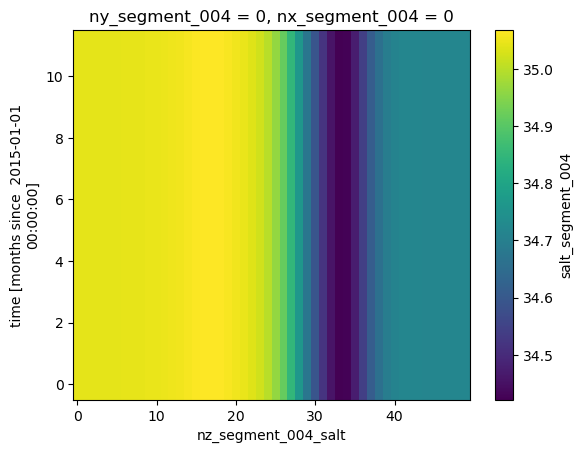

In [45]:
file.salt_segment_004.isel(ny_segment_004 = 0,nx_segment_004 = 0).plot()

In [ ]:
print(file["salt_segment_001"][0,:,0,0].values)
print(saltmean.values)

[35.04231  35.04231  35.04231  35.04231  35.04231  35.04231  35.042725
 35.04348  35.044334 35.045536 35.04699  35.04887  35.05123  35.054955
 35.059162 35.06337  35.06672  35.067722 35.066288 35.06154  35.054646
 35.04636  35.035843 35.02213  34.999546 34.964283 34.914654 34.846146
 34.764534 34.675438 34.59151  34.51794  34.456936 34.421597 34.426506
 34.473835 34.542503 34.60929  34.657093 34.692562 34.710766 34.717583
 34.71923  34.717655 34.71639  34.717575 34.71801        nan       nan
       nan]
[35.04230841 35.04454747 35.04749851 35.05097974 35.05584111 35.06048394
 35.06423863 35.0667098  35.06772317 35.06772296 35.06665147 35.06452048
 35.06199219 35.05908918 35.05602025 35.05290286 35.0497307  35.04646611
 35.04291975 35.03922945 35.03538144 35.03105787 35.02654206 35.02178229
 35.01497593 35.0077975  35.00020237 34.98999971 34.9788562  34.9669595
 34.95250232 34.93645939 34.9192072  34.89827299 34.87484908 34.84954022
 34.82236406 34.79299483 34.76136772 34.72911897 34.69

In [ ]:
file.to_netcdf(inputdir + f"forcing/newnewforcing_obc_segment_{i}.nc")

file.close()

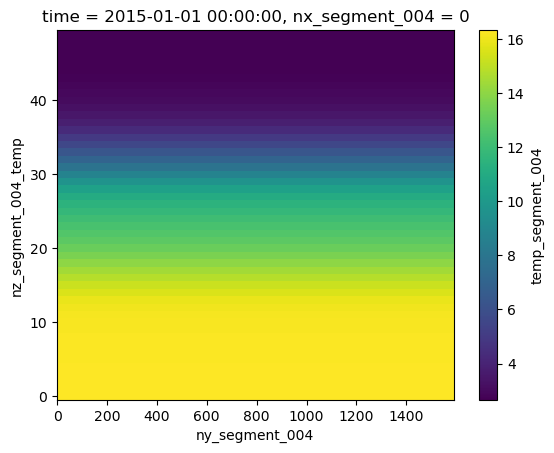

In [ ]:
file[f"temp_segment_{i}"].isel(time = 0,nx_segment_004 = 0).plot()

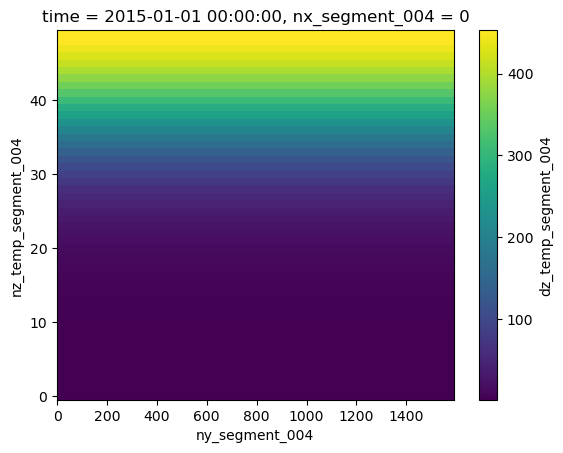

In [ ]:
file[f"dz_temp_segment_{i}"].isel(time = 0,nx_segment_004 = 0).plot()


In [ ]:
tempmean.values

array([16.334852 , 16.31964  , 16.304173 , 16.292929 , 16.28297  ,
       16.273167 , 16.263123 , 16.252266 , 16.23913  , 16.22057  ,
       16.191463 , 16.143652 , 16.054716 , 15.872864 , 15.577693 ,
       15.215364 , 14.825552 , 14.435477 , 14.025571 , 13.602623 ,
       13.220078 , 12.904413 , 12.616409 , 12.333787 , 12.068798 ,
       11.794351 , 11.456826 , 11.021788 , 10.440081 ,  9.693733 ,
        8.791517 ,  7.8797736,  7.010858 ,  6.30629  ,  5.5498114,
        4.943329 ,  4.305611 ,  3.8207967,  3.4913342,  3.239367 ,
        3.0671957,  2.942686 ,  2.8507063,  2.7630594,  2.708772 ,
        2.6820762,  2.6656883,  2.6603816,  2.6601305,  2.6601305],
      dtype=float32)

In [ ]:
i = "001"
file = xr.open_dataset(inputdir + f"forcing/forcing_obc_segment_{i}.nc",chunks={f"ny_segment_{i}":50,f"nx_segment_{i}":50})
file

<xarray.Dataset>
Dimensions:              (time: 364, nz_segment_001_u: 50, ny_segment_001: 1,
                          nx_segment_001: 1521, nz_segment_001_v: 50,
                          nz_segment_001_salt: 50, nz_segment_001_temp: 50,
                          nz_salt_segment_001: 50, nz_temp_segment_001: 50,
                          nz_u_segment_001: 50, nz_v_segment_001: 50)
Coordinates:
  * time                 (time) object 2015-01-01 00:00:00 ... 2015-12-30 00:...
  * nz_segment_001_salt  (nz_segment_001_salt) int32 0 1 2 3 4 ... 46 47 48 49
  * nz_segment_001_temp  (nz_segment_001_temp) int32 0 1 2 3 4 ... 46 47 48 49
  * nz_segment_001_u     (nz_segment_001_u) int32 0 1 2 3 4 5 ... 45 46 47 48 49
  * nz_segment_001_v     (nz_segment_001_v) int32 0 1 2 3 4 5 ... 45 46 47 48 49
  * nx_segment_001       (nx_segment_001) int32 0 1 2 3 ... 1517 1518 1519 1520
  * ny_segment_001       (ny_segment_001) int32 0
Dimensions without coordinates: nz_salt_segment_001, nz_temp_segment_001,
                                nz_u_segment_001, nz_v_segment_001
Data variables:
    u_segment_001        (time, nz_segment_001_u, ny_segment_001, nx_segment_001) float32 dask.array<chunksize=(364, 50, 1, 50), meta=np.ndarray>
    v_segment_001        (time, nz_segment_001_v, ny_segment_001, nx_segment_001) float32 dask.array<chunksize=(364, 50, 1, 50), meta=np.ndarray>
    eta_segment_001      (time, ny_segment_001, nx_segment_001) float32 dask.array<chunksize=(364, 1, 50), meta=np.ndarray>
    salt_segment_001     (time, nz_segment_001_salt, ny_segment_001, nx_segment_001) float32 dask.array<chunksize=(364, 50, 1, 50), meta=np.ndarray>
    temp_segment_001     (time, nz_segment_001_temp, ny_segment_001, nx_segment_001) float32 dask.array<chunksize=(364, 50, 1, 50), meta=np.ndarray>
    dz_salt_segment_001  (time, nz_salt_segment_001, ny_segment_001, nx_segment_001) float32 dask.array<chunksize=(364, 50, 1, 50), meta=np.ndarray>
    dz_temp_segment_001  (time, nz_temp_segment_001, ny_segment_001, nx_segment_001) float32 dask.array<chunksize=(364, 50, 1, 50), meta=np.ndarray>
    dz_u_segment_001     (time, nz_u_segment_001, ny_segment_001, nx_segment_001) float32 dask.array<chunksize=(364, 50, 1, 50), meta=np.ndarray>
    dz_v_segment_001     (time, nz_v_segment_001, ny_segment_001, nx_segment_001) float32 dask.array<chunksize=(364, 50, 1, 50), meta=np.ndarray>
    lon_segment_001      (ny_segment_001, nx_segment_001) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
    lat_segment_001      (ny_segment_001, nx_segment_001) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## Modify boundary segments
Just to simplify things for a test case, let's set all boundary forcing files to zero but leave them otherwise where they were

In [ ]:

for i in ["001","002","003","004"]:
    file = xr.open_dataset(inputdir + f"forcing/forcing_obc_segment_{i}.nc",chunks="auto")
    file[f"u_segment_{i}"][:,:,:,:] = 0
    file[f"v_segment_{i}"][:,:,:,:] = 0

    file.to_netcdf(inputdir + f"forcing/newforcing_obc_segment_{i}.nc")
    file.close()



In [ ]:
a = expt.ocean_forcing(
    tmpdir,  ## Path to ocean foring files
    {"time":"time","y":"latitude","x":"longitude",
     "zl":"depth","eta":"zos","u":"uo","v":"vo",
     "tracers":{"salt":"so","temp":"thetao"}},
    # boundaries = ["south","north","west","east"]
    )

INITIAL CONDITIONS
Regridding Velocities...Done.
Regridding Tracers...
Done.
Regridding Free surface...
Saving outputs... done.


## Add Tides to an Existing Run
Offline I've copied all the inputs from the ttide-20 run. All that this notebook does is use the out-of-the-box NWA scripts to add tidal constituents. I'll then need to go back to the MOM_input file from my old tide test to rectify the new one 

In [ ]:
print(tides.lon_u.isel(nx = 1100,ny = 0).values)
print(tides.lat_u.isel(nx = 1100,ny = 380).values)

183.41667
-26.666668


## Modify the default input directory to make a (hopefully) runnable configuration out of the box

In [ ]:
subprocess.run(f"cp /home/149/ab8992/mom6_rundirs/ttide/blank-ttide-20/* {rundir}",shell = True)
subprocess.run(f"ln -s {inputdir} {rundir}/inputdir",shell=True)
# subprocess.run(f"ln -s {inputdir} {rundir}/inputdir",shell=True)

hgrid = xr.open_dataset(f"{inputdir}/hgrid.nc")



## Get mask table information
ncpus = 100
mask_table = None
for i in os.listdir(f"{inputdir}"):
    if "mask_table" in i:
        mask_table = i
        a = mask_table.split(".")[1]
        b = mask_table.split(".")[2].split("x")
        ncpus = int(b[0]) * int(b[1]) - int(a)


## Modify MOM_input
inputfile = open(f"{rundir}/MOM_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        if mask_table != None:
            lines[i] = f'MASKTABLE = "{mask_table}"\n'
        else:
            lines[i] = "# MASKTABLE = no mask table"
    if "NIGLOBAL" in lines[i]: 
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"
    if "LAYOUT =" in lines[i] and "IO" not in lines[i]:
        lines[i] = f'LAYOUT = {expt.layout[1]},{expt.layout[0]}\n'
        
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"

        
inputfile = open(f"{rundir}/MOM_input",'w')

inputfile.writelines(lines)
inputfile.close()

## Modify SIS_input
inputfile = open(f"{rundir}/SIS_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        lines[i] = f'MASKTABLE = "{mask_table}"\n'
    if "NIGLOBAL" in lines[i]:
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"
    if "LAYOUT =" in lines[i] and "IO" not in lines[i]:
        lines[i] = f'LAYOUT = {expt.layout[1]},{expt.layout[0]}\n'
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"
        
inputfile = open(f"{rundir}/SIS_input",'w')
inputfile.writelines(lines)
inputfile.close()

## Modify config.yaml 
inputfile = open(f"{rundir}/config.yaml",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "ncpus" in lines[i]:
        lines[i] = f'ncpus: {str(ncpus)}\n'
    if "jobname" in lines[i]:
        lines[i] = f"jobname: mom6_{expt_name}\n"
        
    if "input:" in lines[i]:
        lines[i + 1] = f"    - {inputdir}\n"
        
inputfile = open(f"{rundir}/config.yaml",'w')
inputfile.writelines(lines)
inputfile.close()

## Modify data table
text = """
"ATM", "p_surf", "sp", "./INPUT/forcing/sp_ERA5", "bilinear", 1.0
"ATM", "p_bot",  "sp", "./INPUT/forcing/sp_ERA5", "bilinear", 1.0
"ATM", "t_bot",  "t2m", "./INPUT/forcing/2t_ERA5", "bilinear", 1.0
"ATM", "sphum_bot", "q", "./INPUT/forcing/q_ERA5", "bilinear", 1.0
"ATM", "u_bot", "u10", "./INPUT/forcing/10u_ERA5", "bicubic", 1.0
"ATM", "v_bot", "v10", "./INPUT/forcing/10v_ERA5", "bicubic", 1.0
"ATM", "z_bot", "", "", "bilinear", 10.0
"ATM", "gust", "", "", "bilinear", 1.0e-4
"ICE", "lw_flux_dn", "rlds", "./INPUT/RYF.rlds.1990_1991.nc", "bilinear", 1.0
"ICE", "sw_flux_vis_dir_dn", "rsds", "./INPUT/RYF.rsds.1990_1991.nc", "bilinear", 0.285
"ICE", "sw_flux_vis_dif_dn", "rsds", "./INPUT/RYF.rsds.1990_1991.nc", "bilinear", 0.285
"ICE", "sw_flux_nir_dir_dn", "rsds", "./INPUT/RYF.rsds.1990_1991.nc", "bilinear", 0.215
"ICE", "sw_flux_nir_dif_dn", "rsds", "./INPUT/RYF.rsds.1990_1991.nc", "bilinear", 0.215
"ICE", "lprec", "prrn", "./INPUT/RYF.rain.1990_1991.nc", "bilinear", 1.0
"ICE", "fprec", "prsn", "./INPUT/RYF.snow.1990_1991.nc", "bilinear", 1.0
"ICE", "runoff", "friver", "./INPUT/runoff_regrid.nc", "none", 1.0
"ICE", "dhdt", "", "", "none", 80.0
"ICE", "dedt", "", "", "none", 2.0e-6
"ICE", "drdt", "", "", "none", 10.0
"LND", "rough_mom", "", "", "none", 0.01
"LND", "rough_heat", "", "", "none", 0.1"""
inputfile = open(f"{rundir}/data_table",'w')
inputfile.writelines(text)
inputfile.close()

## Modify namelist to set start date
inputfile = open(f"{rundir}/input.nml",'r')
lines = inputfile.readlines()
inputfile.close()

for i in enumerate(lines):
    if "current_date" in i[1]:
        d = dt.datetime.strptime(daterange[0],"%Y-%m-%d %H:%M:%S")
        lines[i[0]] = lines[i[0]].split("=")[0] + f"= {d.year},{d.month},{d.day},{d.hour},{d.minute},{d.second},\n" 

inputfile = open(f"{rundir}/input.nml",'w')
inputfile.writelines(lines)
inputfile.close()


cp: -r not specified; omitting directory '/home/149/ab8992/mom6_rundirs/ttide/blank-ttide-20/archive'
cp: -r not specified; omitting directory '/home/149/ab8992/mom6_rundirs/ttide/blank-ttide-20/blank-ttide-20'
cp: -r not specified; omitting directory '/home/149/ab8992/mom6_rundirs/ttide/blank-ttide-20/inputdir'
cp: -r not specified; omitting directory '/home/149/ab8992/mom6_rundirs/ttide/blank-ttide-20/manifests'
cp: -r not specified; omitting directory '/home/149/ab8992/mom6_rundirs/ttide/blank-ttide-20/work'
ln: failed to create symbolic link '/home/149/ab8992/mom6_rundirs/ttide/blank-ttide-bodyforce-20//inputdir/blank-ttide-bodyforce-20': File exists


check bounds of regional selection

In [28]:
data = xr.open_dataset("/home/149/ab8992/mom6_rundirs/ttide/blank-ttide-20/archive/output002/20150131.ocean_6hourly.nc")

data.yh.sel(yh = -41,method = "nearest").astype(float)

<xarray.DataArray 'yh' ()>
array(-41.)
Coordinates:
    yh       float64 -41.0
Attributes:
    units:      degrees_north
    long_name:  h point nominal latitude
    axis:       Y

In [32]:
data.u.sel(yh = -41)

<xarray.DataArray 'u' (time: 120, zl: 100, xq: 761)>
[9132000 values with dtype=float32]
Coordinates:
  * zl       (zl) float64 2.704 8.126 13.58 ... 5.236e+03 5.339e+03 5.696e+03
  * time     (time) object 2015-01-31 03:00:00 ... 2015-03-01 21:00:00
  * xq       (xq) float64 142.0 142.1 142.1 142.2 ... 179.8 179.9 179.9 180.0
    yh       float64 -41.0
Attributes:
    units:          m s-1
    long_name:      Zonal velocity
    cell_methods:   zl:mean yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  none

In [20]:
data.yh.sel(yh = -39.98113208)

KeyError: "not all values found in index 'yh'. Try setting the `method` keyword argument (example: method='nearest')."